In [1]:
from transformers import CLIPTokenizer
from datasets import load_dataset
from datasets import Image as HuggingFaceImage
from linformer import Linformer
from vit_pytorch.efficient import ViT
from dalle2_pytorch.tokenizer import tokenizer
import torch
from tqdm import tqdm 

def get_tokenizer() -> CLIPTokenizer:
    return CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
def get_tokenizer2():
    return tokenizer
def prepare_data(tokenizer):
    def add_prompt(example):
        props = example['font_properties']
        character = example['character']
        split = character.split('_')
        if len(split) > 1:
            character = split[0] + 'case ' + split[1]
        else:
            character = split[0]
        prompt = f"a {props['font_serifs']} {character} with {props['width']} width {props['rounding']} corners {props['font_weight']} weight and {props['dynamics']} movement with characteristics that can be described by adjectives {example['font_characteristics']}" 
        example['prompt'] = prompt
        return example
    def map_tokens(example):
        prompt = example['prompt']
        tokens = tokenizer.encode(prompt, padding='max_length', max_length=256)
        #tokens = tokenizer.encode(prompt)
        example['tokens'] = tokens
        return example
    dataset = load_dataset('json', data_files={'train':'train-metadata.jsonl', 'test':'test-metadata.jsonl'})
    
    train_new_column = ['foo'] * len(dataset['train'])
    dataset['train'] = dataset['train'].add_column('prompt', train_new_column)
    dataset['train'] = dataset['train'].add_column('tokens', train_new_column)
    dataset['train'] = dataset['train'].map(add_prompt)
    dataset['train'] = dataset['train'].map(map_tokens)
    dataset['train'] = dataset['train'].remove_columns(['prompt', 'uniqueId', 'ttf_path', 'font_characteristics', 'font_properties', 'character', 'vit_label'])
    dataset['train'] = dataset['train'].cast_column('image', HuggingFaceImage())
    dataset['train'] = dataset['train'].with_format('torch')
    
    test_new_column = ['bar'] * len(dataset['test'])
    dataset['test'] = dataset['test'].add_column('prompt', test_new_column)
    dataset['test'] = dataset['test'].add_column('tokens', test_new_column)
    dataset['test'] = dataset['test'].map(add_prompt)
    dataset['test'] = dataset['test'].map(map_tokens)
    dataset['test'] = dataset['test'].remove_columns(['prompt', 'uniqueId', 'ttf_path', 'font_characteristics', 'font_properties', 'character', 'vit_label'])
    dataset['test'] = dataset['test'].cast_column('image', HuggingFaceImage())
    dataset['test'] = dataset['test'].with_format('torch')
    return dataset
def get_vit_model(image_size: int, patch_size: int, dim: int, depth: int, num_heads: int, k: int, device: str):
    sequence_length = (image_size//patch_size)**2 + 1
    # for 512x512px image with 32x32px patches: 16x16 + 1 CLS token
    efficient_transformer = Linformer(
        dim=dim,
        seq_len=sequence_length,  
        depth=depth,
        heads=num_heads,
        k=k
    )
    model = ViT(
        dim=dim,
        image_size=image_size,
        patch_size=patch_size,
        num_classes=62,
        transformer=efficient_transformer,
        channels=1,
    )
    return model 
def get_vit(image_size, patch_size, vit_dim, vit_depth, vit_num_heads, k, device, vit_checkpoint_path):
    vit = get_vit_model(image_size=image_size, 
                        patch_size=patch_size, 
                        dim=vit_dim, 
                        depth=vit_depth, 
                        num_heads=vit_num_heads, 
                        k=k, 
                        device=device)
    if vit_checkpoint_path != None:
        vit_checkpoint = torch.load(vit_checkpoint_path)
        vit.load_state_dict(vit_checkpoint['model_state_dict'])
        print('Loaded ViT model from checkpoint:', vit_checkpoint_path)
    return vit


### Training Decoder/Prior: OpenAI CLIP 

#### Get Data

In [2]:
import numpy as np 
dataset = prepare_data(get_tokenizer())
#images_tensor = dataset['train'][0:2]['image']
#texts_tensor = dataset['train'][0:2]['tokens']


#images_tensor = images_tensor.permute(0, 3, 1, 2)
#images_tensor = images_tensor.float()

#print(images_tensor.shape)
#print(texts_tensor.shape)


Found cached dataset json (C:/Users/rinat/.cache/huggingface/datasets/json/default-1e07ea3eabca7683/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\rinat\.cache\huggingface\datasets\json\default-1e07ea3eabca7683\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-54018895e1b774e9.arrow
Loading cached processed dataset at C:\Users\rinat\.cache\huggingface\datasets\json\default-1e07ea3eabca7683\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-8115de56d8df858f.arrow
Loading cached processed dataset at C:\Users\rinat\.cache\huggingface\datasets\json\default-1e07ea3eabca7683\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-2ad7280546491b5e.arrow
Loading cached processed dataset at C:\Users\rinat\.cache\huggingface\datasets\json\default-1e07ea3eabca7683\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-5c61c0fc59a2958d.arrow


#### Train the Decoder 

In [3]:
import torch
from dalle2_pytorch import DALLE2, Unet, Decoder, OpenAIClipAdapter
from dalle2_pytorch import DecoderTrainer
# openai pretrained clip - defaults to ViT-B/32
n_epochs = 1
print_loss_every = 500
clip = OpenAIClipAdapter()

# decoder (with unet)

unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    text_embed_dim = 512,
    cond_on_text_encodings = True  # set to True for any unets that need to be conditioned on text encodings (ex. first unet in cascade)
).cuda()

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = clip,
    timesteps = 1000,
    sample_timesteps = (250, 27),
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

decoder_trainer = DecoderTrainer(
    decoder,
    lr = 1e-5,
    wd = 1e-2,
    ema_beta = 0.99,
    ema_update_after_step = 1000,
    ema_update_every = 10,
)

for epoch in range(n_epochs):
    print('Epoch: ', epoch)
    u1_loss = 0 
    u2_loss = 0

    for i, data in enumerate(tqdm(dataset['train'])):
        img, emb = data['image'], data['tokens'] 
        img = img.unsqueeze(0)
        emb = emb.unsqueeze(0)
        img = img.permute(0, 3, 1, 2)
        img = img.float()

        for unet_number in (1, 2):
            loss = decoder_trainer(
                img,
                text = emb,
                unet_number = unet_number, # which unet to train on
                max_batch_size = 4         # gradient accumulation - this sets the maximum batch size in which to do forward and backwards pass - for this example 32 / 4 == 8 times
            )

            if i % print_loss_every == 0:
                print('Batch ', i)
                print('Loss:', loss)
            decoder_trainer.update(unet_number)

        if i%100 == 0:
            print('Saving decoder model...')
            decoder_trainer.save("best_decoder.pth")
print('Saving last decoder')
decoder_trainer.save("last_decoder.pth")

Epoch:  0


  0%|          | 0/12090 [00:00<?, ?it/s]

Batch  0
Loss: 1.0043487548828125
Batch  0
Loss: 1.0021426677703857
Saving decoder model...


  1%|          | 100/12090 [01:02<1:51:43,  1.79it/s]

Batch  100
Loss: 0.6581845879554749
Batch  100
Loss: 1.0761290788650513
Saving decoder model...


  2%|▏         | 200/12090 [02:01<1:39:16,  2.00it/s]

Batch  200
Loss: 1.4763939380645752
Batch  200
Loss: 0.6246916055679321
Saving decoder model...


  2%|▏         | 300/12090 [03:02<1:51:20,  1.76it/s]

Batch  300
Loss: 2.0950543880462646
Batch  300
Loss: 0.6427910327911377
Saving decoder model...


  3%|▎         | 400/12090 [04:02<1:43:36,  1.88it/s]

Batch  400
Loss: 0.44975772500038147
Batch  400
Loss: 0.9298602342605591
Saving decoder model...


  4%|▍         | 500/12090 [04:59<1:42:20,  1.89it/s]

Batch  500
Loss: 0.574957549571991
Batch  500
Loss: 0.17286932468414307
Saving decoder model...


  5%|▍         | 600/12090 [06:00<1:41:16,  1.89it/s]

Batch  600
Loss: 0.3430556654930115
Batch  600
Loss: 0.6291264891624451
Saving decoder model...


  6%|▌         | 700/12090 [06:58<1:43:21,  1.84it/s]

Batch  700
Loss: 0.07377719134092331
Batch  700
Loss: 0.03940613567829132
Saving decoder model...


  7%|▋         | 800/12090 [08:00<1:46:02,  1.77it/s]

Batch  800
Loss: 0.14477425813674927
Batch  800
Loss: 0.0780532956123352
Saving decoder model...


  7%|▋         | 900/12090 [08:54<1:28:35,  2.11it/s]

Batch  900
Loss: nan
Batch  900
Loss: nan
Saving decoder model...


  8%|▊         | 1000/12090 [09:52<1:49:24,  1.69it/s]

Batch  1000
Loss: nan
Batch  1000
Loss: nan
Saving decoder model...


  9%|▉         | 1100/12090 [10:50<1:29:03,  2.06it/s]

Batch  1100
Loss: nan
Batch  1100
Loss: nan
Saving decoder model...


 10%|▉         | 1200/12090 [11:43<1:27:22,  2.08it/s]

Batch  1200
Loss: nan
Batch  1200
Loss: nan
Saving decoder model...


 11%|█         | 1300/12090 [12:41<1:48:11,  1.66it/s]

Batch  1300
Loss: nan
Batch  1300
Loss: nan
Saving decoder model...


 12%|█▏        | 1400/12090 [13:39<1:40:19,  1.78it/s]

Batch  1400
Loss: nan
Batch  1400
Loss: nan
Saving decoder model...


 12%|█▏        | 1469/12090 [14:22<1:43:59,  1.70it/s]


KeyboardInterrupt: 

#### Train the Prior 

In [9]:
#### Train the Prior 
from dalle2_pytorch import DiffusionPrior, DiffusionPriorNetwork, DiffusionPriorTrainer
from dalle2_pytorch import OpenAIClipAdapter

n_epochs = 1
print_loss_every = 500

clip = OpenAIClipAdapter()

prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()

diffusion_prior_trainer = DiffusionPriorTrainer(
    diffusion_prior,
    lr = 1e-5,
    wd = 1e-2,
    ema_beta = 0.99,
    ema_update_after_step = 1000,
    ema_update_every = 10,
)

for i, data in enumerate(tqdm(dataset['train'])):
        img, emb = data['image'], data['tokens'] 
        img = img.unsqueeze(0)
        emb = emb.unsqueeze(0)
        img = img.permute(0, 3, 1, 2)
        img = img.float()

        loss = diffusion_prior_trainer(emb, img, max_batch_size = 4)


        if i % print_loss_every == 0:
            print('Batch ', i)
            print('Loss:', loss)
        diffusion_prior_trainer.update()

        if i%100 == 0:
            print('Saving prior model...')
            diffusion_prior_trainer.save("best_prior.pth")
print('Saving last prior model')
diffusion_prior_trainer.save("last_prior.pth")

  0%|          | 0/12090 [00:00<?, ?it/s]

Batch  0
Loss: 1.3394761085510254
Saving prior model...
Saving checkpoint at step: 1


  1%|          | 99/12090 [00:10<17:44, 11.26it/s] 

Saving prior model...
Saving checkpoint at step: 101


  2%|▏         | 200/12090 [00:20<17:52, 11.09it/s]

Saving prior model...
Saving checkpoint at step: 201


  2%|▏         | 300/12090 [00:30<17:37, 11.15it/s]

Saving prior model...
Saving checkpoint at step: 301


  3%|▎         | 400/12090 [00:41<18:08, 10.74it/s]

Saving prior model...
Saving checkpoint at step: 401


  4%|▍         | 499/12090 [00:52<18:24, 10.49it/s]

Batch  500
Loss: 0.0503176786005497
Saving prior model...
Saving checkpoint at step: 501


  5%|▍         | 600/12090 [01:03<17:56, 10.68it/s]

Saving prior model...
Saving checkpoint at step: 601


  6%|▌         | 700/12090 [01:13<18:04, 10.50it/s]

Saving prior model...
Saving checkpoint at step: 701


  7%|▋         | 799/12090 [01:24<18:02, 10.43it/s]

Saving prior model...
Saving checkpoint at step: 801


  7%|▋         | 899/12090 [01:34<16:44, 11.15it/s]

Saving prior model...
Saving checkpoint at step: 901


  8%|▊         | 999/12090 [01:45<17:25, 10.61it/s]

Batch  1000
Loss: 0.040028274059295654
Saving prior model...
Saving checkpoint at step: 1001


  9%|▉         | 1099/12090 [01:55<16:47, 10.91it/s]

Saving prior model...
Saving checkpoint at step: 1101


 10%|▉         | 1199/12090 [02:06<16:30, 10.99it/s]

Saving prior model...
Saving checkpoint at step: 1201


 11%|█         | 1299/12090 [02:16<16:39, 10.80it/s]

Saving prior model...
Saving checkpoint at step: 1301


 12%|█▏        | 1400/12090 [02:27<16:44, 10.64it/s]

Saving prior model...
Saving checkpoint at step: 1401


 12%|█▏        | 1499/12090 [02:38<16:51, 10.47it/s]

Batch  1500
Loss: 0.012066573835909367
Saving prior model...
Saving checkpoint at step: 1501


 13%|█▎        | 1599/12090 [02:49<17:25, 10.04it/s]

Saving prior model...
Saving checkpoint at step: 1601


 14%|█▍        | 1699/12090 [03:00<16:44, 10.35it/s]

Saving prior model...
Saving checkpoint at step: 1701


 15%|█▍        | 1799/12090 [03:10<16:18, 10.51it/s]

Saving prior model...
Saving checkpoint at step: 1801


 16%|█▌        | 1899/12090 [03:21<16:06, 10.54it/s]

Saving prior model...
Saving checkpoint at step: 1901


 17%|█▋        | 1999/12090 [03:31<15:25, 10.90it/s]

Batch  2000
Loss: 0.020679708570241928
Saving prior model...
Saving checkpoint at step: 2001


 17%|█▋        | 2099/12090 [03:42<15:07, 11.00it/s]

Saving prior model...
Saving checkpoint at step: 2101


 18%|█▊        | 2199/12090 [03:52<15:06, 10.91it/s]

Saving prior model...
Saving checkpoint at step: 2201


 19%|█▉        | 2299/12090 [04:03<15:17, 10.67it/s]

Saving prior model...
Saving checkpoint at step: 2301


 20%|█▉        | 2400/12090 [04:14<15:48, 10.21it/s]

Saving prior model...
Saving checkpoint at step: 2401


 21%|██        | 2500/12090 [04:25<14:45, 10.84it/s]

Batch  2500
Loss: 0.05247374624013901
Saving prior model...
Saving checkpoint at step: 2501


 21%|██▏       | 2599/12090 [04:35<14:47, 10.70it/s]

Saving prior model...
Saving checkpoint at step: 2601


 22%|██▏       | 2699/12090 [04:46<14:13, 11.00it/s]

Saving prior model...
Saving checkpoint at step: 2701


 23%|██▎       | 2799/12090 [04:56<13:56, 11.11it/s]

Saving prior model...
Saving checkpoint at step: 2801


 24%|██▍       | 2899/12090 [05:07<14:20, 10.68it/s]

Saving prior model...
Saving checkpoint at step: 2901


 25%|██▍       | 3000/12090 [05:18<13:50, 10.94it/s]

Batch  3000
Loss: 0.03938603028655052
Saving prior model...
Saving checkpoint at step: 3001


 26%|██▌       | 3099/12090 [05:28<14:41, 10.20it/s]

Saving prior model...
Saving checkpoint at step: 3101


 26%|██▋       | 3199/12090 [05:39<14:14, 10.40it/s]

Saving prior model...
Saving checkpoint at step: 3201


 27%|██▋       | 3299/12090 [05:49<13:16, 11.04it/s]

Saving prior model...
Saving checkpoint at step: 3301


 28%|██▊       | 3399/12090 [05:59<13:05, 11.06it/s]

Saving prior model...
Saving checkpoint at step: 3401


 29%|██▉       | 3500/12090 [06:10<12:42, 11.27it/s]

Batch  3500
Loss: 0.08618474006652832
Saving prior model...
Saving checkpoint at step: 3501


 30%|██▉       | 3600/12090 [06:20<12:38, 11.19it/s]

Saving prior model...
Saving checkpoint at step: 3601


 31%|███       | 3700/12090 [06:31<12:28, 11.20it/s]

Saving prior model...
Saving checkpoint at step: 3701


 31%|███▏      | 3799/12090 [06:41<13:06, 10.54it/s]

Saving prior model...
Saving checkpoint at step: 3801


 32%|███▏      | 3899/12090 [06:51<12:39, 10.78it/s]

Saving prior model...
Saving checkpoint at step: 3901


 33%|███▎      | 3999/12090 [07:02<12:00, 11.23it/s]

Batch  4000
Loss: 0.041893236339092255
Saving prior model...
Saving checkpoint at step: 4001


 34%|███▍      | 4100/12090 [07:12<11:41, 11.39it/s]

Saving prior model...
Saving checkpoint at step: 4101


 35%|███▍      | 4199/12090 [07:23<11:37, 11.31it/s]

Saving prior model...
Saving checkpoint at step: 4201


 36%|███▌      | 4300/12090 [07:33<11:17, 11.50it/s]

Saving prior model...
Saving checkpoint at step: 4301


 36%|███▋      | 4400/12090 [07:44<12:10, 10.52it/s]

Saving prior model...
Saving checkpoint at step: 4401


 37%|███▋      | 4499/12090 [07:54<11:08, 11.36it/s]

Batch  4500
Loss: 0.057119447737932205
Saving prior model...
Saving checkpoint at step: 4501


 38%|███▊      | 4599/12090 [08:04<10:54, 11.45it/s]

Saving prior model...
Saving checkpoint at step: 4601


 39%|███▉      | 4699/12090 [08:14<11:27, 10.75it/s]

Saving prior model...
Saving checkpoint at step: 4701


 40%|███▉      | 4799/12090 [08:25<11:12, 10.84it/s]

Saving prior model...
Saving checkpoint at step: 4801


 41%|████      | 4900/12090 [08:35<10:29, 11.41it/s]

Saving prior model...
Saving checkpoint at step: 4901


 41%|████▏     | 5000/12090 [08:46<11:07, 10.62it/s]

Batch  5000
Loss: 0.03016403131186962
Saving prior model...
Saving checkpoint at step: 5001


 42%|████▏     | 5100/12090 [08:56<10:44, 10.84it/s]

Saving prior model...
Saving checkpoint at step: 5101


 43%|████▎     | 5200/12090 [09:07<10:06, 11.36it/s]

Saving prior model...
Saving checkpoint at step: 5201


 44%|████▍     | 5300/12090 [09:17<10:06, 11.19it/s]

Saving prior model...
Saving checkpoint at step: 5301


 45%|████▍     | 5400/12090 [09:28<10:12, 10.92it/s]

Saving prior model...
Saving checkpoint at step: 5401


 45%|████▌     | 5499/12090 [09:38<09:58, 11.01it/s]

Batch  5500
Loss: 0.03418148681521416
Saving prior model...
Saving checkpoint at step: 5501


 46%|████▋     | 5600/12090 [09:48<09:47, 11.04it/s]

Saving prior model...
Saving checkpoint at step: 5601


 47%|████▋     | 5699/12090 [09:58<09:25, 11.29it/s]

Saving prior model...
Saving checkpoint at step: 5701


 48%|████▊     | 5799/12090 [10:09<10:04, 10.41it/s]

Saving prior model...
Saving checkpoint at step: 5801


 49%|████▉     | 5899/12090 [10:19<09:16, 11.12it/s]

Saving prior model...
Saving checkpoint at step: 5901


 50%|████▉     | 5999/12090 [10:30<08:58, 11.32it/s]

Batch  6000
Loss: 0.02560434862971306
Saving prior model...
Saving checkpoint at step: 6001


 50%|█████     | 6099/12090 [10:40<09:03, 11.02it/s]

Saving prior model...
Saving checkpoint at step: 6101


 51%|█████▏    | 6199/12090 [10:50<08:46, 11.19it/s]

Saving prior model...
Saving checkpoint at step: 6201


 52%|█████▏    | 6300/12090 [11:01<09:09, 10.53it/s]

Saving prior model...
Saving checkpoint at step: 6301


 53%|█████▎    | 6400/12090 [11:11<08:47, 10.80it/s]

Saving prior model...
Saving checkpoint at step: 6401


 54%|█████▍    | 6499/12090 [11:22<08:09, 11.42it/s]

Batch  6500
Loss: 0.011082777753472328
Saving prior model...
Saving checkpoint at step: 6501


 55%|█████▍    | 6599/12090 [11:32<08:21, 10.95it/s]

Saving prior model...
Saving checkpoint at step: 6601


 55%|█████▌    | 6699/12090 [11:42<07:59, 11.24it/s]

Saving prior model...
Saving checkpoint at step: 6701


 56%|█████▌    | 6799/12090 [11:53<07:42, 11.45it/s]

Saving prior model...
Saving checkpoint at step: 6801


 57%|█████▋    | 6899/12090 [12:03<07:36, 11.37it/s]

Saving prior model...
Saving checkpoint at step: 6901


 58%|█████▊    | 7000/12090 [12:14<07:35, 11.18it/s]

Batch  7000
Loss: 0.00894743762910366
Saving prior model...
Saving checkpoint at step: 7001


 59%|█████▊    | 7099/12090 [12:24<08:29,  9.79it/s]

Saving prior model...
Saving checkpoint at step: 7101


 60%|█████▉    | 7200/12090 [12:35<07:14, 11.26it/s]

Saving prior model...
Saving checkpoint at step: 7201


 60%|██████    | 7299/12090 [12:46<07:22, 10.83it/s]

Saving prior model...
Saving checkpoint at step: 7301


 61%|██████    | 7400/12090 [12:56<07:29, 10.43it/s]

Saving prior model...
Saving checkpoint at step: 7401


 62%|██████▏   | 7500/12090 [13:07<06:45, 11.31it/s]

Batch  7500
Loss: 0.04396612197160721
Saving prior model...
Saving checkpoint at step: 7501


 63%|██████▎   | 7600/12090 [13:17<06:46, 11.05it/s]

Saving prior model...
Saving checkpoint at step: 7601


 64%|██████▎   | 7700/12090 [13:28<06:55, 10.57it/s]

Saving prior model...
Saving checkpoint at step: 7701


 65%|██████▍   | 7800/12090 [13:39<06:51, 10.41it/s]

Saving prior model...
Saving checkpoint at step: 7801


 65%|██████▌   | 7899/12090 [13:49<06:27, 10.80it/s]

Saving prior model...
Saving checkpoint at step: 7901


 66%|██████▌   | 8000/12090 [14:00<06:39, 10.25it/s]

Batch  8000
Loss: 0.04007840156555176
Saving prior model...
Saving checkpoint at step: 8001


 67%|██████▋   | 8100/12090 [14:10<05:49, 11.41it/s]

Saving prior model...
Saving checkpoint at step: 8101


 68%|██████▊   | 8200/12090 [14:20<06:01, 10.77it/s]

Saving prior model...
Saving checkpoint at step: 8201


 69%|██████▊   | 8300/12090 [14:30<05:44, 11.01it/s]

Saving prior model...
Saving checkpoint at step: 8301


 69%|██████▉   | 8400/12090 [14:41<05:22, 11.46it/s]

Saving prior model...
Saving checkpoint at step: 8401


 70%|███████   | 8500/12090 [14:51<05:22, 11.12it/s]

Batch  8500
Loss: 0.024765610694885254
Saving prior model...
Saving checkpoint at step: 8501


 71%|███████   | 8599/12090 [15:01<05:17, 11.00it/s]

Saving prior model...
Saving checkpoint at step: 8601


 72%|███████▏  | 8699/12090 [15:12<05:12, 10.85it/s]

Saving prior model...
Saving checkpoint at step: 8701


 73%|███████▎  | 8800/12090 [15:22<04:54, 11.16it/s]

Saving prior model...
Saving checkpoint at step: 8801


 74%|███████▎  | 8899/12090 [15:32<05:08, 10.33it/s]

Saving prior model...
Saving checkpoint at step: 8901


 74%|███████▍  | 8999/12090 [15:43<04:35, 11.22it/s]

Batch  9000
Loss: 0.0305095873773098
Saving prior model...
Saving checkpoint at step: 9001


 75%|███████▌  | 9099/12090 [15:53<04:21, 11.42it/s]

Saving prior model...
Saving checkpoint at step: 9101


 76%|███████▌  | 9200/12090 [16:04<04:14, 11.34it/s]

Saving prior model...
Saving checkpoint at step: 9201


 77%|███████▋  | 9300/12090 [16:14<04:21, 10.68it/s]

Saving prior model...
Saving checkpoint at step: 9301


 78%|███████▊  | 9399/12090 [16:25<04:00, 11.17it/s]

Saving prior model...
Saving checkpoint at step: 9401


 79%|███████▊  | 9500/12090 [16:35<03:49, 11.28it/s]

Batch  9500
Loss: 0.03989984840154648
Saving prior model...
Saving checkpoint at step: 9501


 79%|███████▉  | 9599/12090 [16:46<03:53, 10.67it/s]

Saving prior model...
Saving checkpoint at step: 9601


 80%|████████  | 9699/12090 [16:56<03:49, 10.40it/s]

Saving prior model...
Saving checkpoint at step: 9701


 81%|████████  | 9799/12090 [17:07<03:34, 10.67it/s]

Saving prior model...
Saving checkpoint at step: 9801


 82%|████████▏ | 9900/12090 [17:17<03:11, 11.44it/s]

Saving prior model...
Saving checkpoint at step: 9901


 83%|████████▎ | 9999/12090 [17:28<03:03, 11.37it/s]

Batch  10000
Loss: 0.024997321888804436
Saving prior model...
Saving checkpoint at step: 10001


 84%|████████▎ | 10099/12090 [17:38<02:57, 11.20it/s]

Saving prior model...
Saving checkpoint at step: 10101


 84%|████████▍ | 10199/12090 [17:49<02:57, 10.63it/s]

Saving prior model...
Saving checkpoint at step: 10201


 85%|████████▌ | 10299/12090 [17:59<02:41, 11.08it/s]

Saving prior model...
Saving checkpoint at step: 10301


 86%|████████▌ | 10400/12090 [18:10<02:32, 11.11it/s]

Saving prior model...
Saving checkpoint at step: 10401


 87%|████████▋ | 10500/12090 [18:20<02:29, 10.65it/s]

Batch  10500
Loss: 0.06083837151527405
Saving prior model...
Saving checkpoint at step: 10501


 88%|████████▊ | 10599/12090 [18:30<02:15, 10.99it/s]

Saving prior model...
Saving checkpoint at step: 10601


 88%|████████▊ | 10699/12090 [18:41<02:06, 11.00it/s]

Saving prior model...
Saving checkpoint at step: 10701


 89%|████████▉ | 10799/12090 [18:51<01:59, 10.81it/s]

Saving prior model...
Saving checkpoint at step: 10801


 90%|█████████ | 10899/12090 [19:01<01:49, 10.90it/s]

Saving prior model...
Saving checkpoint at step: 10901


 91%|█████████ | 10999/12090 [19:12<01:41, 10.76it/s]

Batch  11000
Loss: 0.017904827371239662
Saving prior model...
Saving checkpoint at step: 11001


 92%|█████████▏| 11099/12090 [19:23<01:33, 10.61it/s]

Saving prior model...
Saving checkpoint at step: 11101


 93%|█████████▎| 11199/12090 [19:33<01:21, 10.88it/s]

Saving prior model...
Saving checkpoint at step: 11201


 93%|█████████▎| 11300/12090 [19:44<01:11, 11.11it/s]

Saving prior model...
Saving checkpoint at step: 11301


 94%|█████████▍| 11400/12090 [19:54<01:01, 11.22it/s]

Saving prior model...
Saving checkpoint at step: 11401


 95%|█████████▌| 11499/12090 [20:05<00:54, 10.89it/s]

Batch  11500
Loss: 0.022313546389341354
Saving prior model...
Saving checkpoint at step: 11501


 96%|█████████▌| 11600/12090 [20:15<00:45, 10.85it/s]

Saving prior model...
Saving checkpoint at step: 11601


 97%|█████████▋| 11700/12090 [20:26<00:36, 10.65it/s]

Saving prior model...
Saving checkpoint at step: 11701


 98%|█████████▊| 11800/12090 [20:36<00:27, 10.68it/s]

Saving prior model...
Saving checkpoint at step: 11801


 98%|█████████▊| 11900/12090 [20:47<00:16, 11.36it/s]

Saving prior model...
Saving checkpoint at step: 11901


 99%|█████████▉| 12000/12090 [20:57<00:08, 11.24it/s]

Batch  12000
Loss: 0.022122971713542938
Saving prior model...
Saving checkpoint at step: 12001


100%|██████████| 12090/12090 [21:07<00:00,  9.54it/s]


Saving last prior model
Saving checkpoint at step: 12090


#### Sample from the model 

In [6]:
from dalle2_pytorch import DALLE2, Unet, Decoder, OpenAIClipAdapter
from dalle2_pytorch import DiffusionPrior, DiffusionPriorNetwork

clip = OpenAIClipAdapter()
#Load the decoder 
decoder_path = 'best_decoder.pth'
unet1 = Unet(
    dim = 128,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    text_embed_dim = 512,
    cond_on_text_encodings = True  # set to True for any unets that need to be conditioned on text encodings (ex. first unet in cascade)
).cuda()

unet2 = Unet(
    dim = 16,
    image_embed_dim = 512,
    cond_dim = 128,
    channels = 3,
    dim_mults = (1, 2, 4, 8, 16)
).cuda()

decoder = Decoder(
    unet = (unet1, unet2),
    image_sizes = (128, 256),
    clip = clip,
    timesteps = 1000,
    sample_timesteps = (250, 27),
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.5
).cuda()

decoder_model_state = torch.load(decoder_path, map_location='cpu',)['model']
for k in decoder.clip.state_dict().keys():
    decoder_model_state["clip." + k] = decoder.clip.state_dict()[k]

decoder.load_state_dict(decoder_model_state, strict=True)

#Load the prior 
prior_network = DiffusionPriorNetwork(
    dim = 512,
    depth = 6,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 100,
    cond_drop_prob = 0.2
).cuda()


prior_path = 'best_prior.pth'

prior_model_state = torch.load(prior_path, map_location='cpu')['model']
diffusion_prior.load_state_dict(prior_model_state, strict=True) 

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)

images = dalle2(
    ['A lowercase a which has traits blocky and properties black square sans serif static extended all caps'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/27 [00:00<?, ?it/s]

In [7]:
#Save image 
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage

images = images.squeeze(0)
img = ToPILImage()(images)
img.show()
#save_image(images, 'example_output.png')

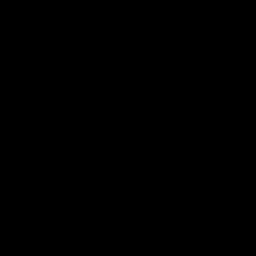

In [10]:
#HugginFaceImage - 512 x 512 x 3 
#Token legnth - 42

#Required format: 
#Image: (B, C, W, H) ~ channels: 3 , W,H: 512 
#Text: (B, T)

img